In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
import numpy as np
from skimage.measure import regionprops
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize
from skimage.color import rgb2hsv
import pandas

# from annotation_utilities import *
# from registration_utilities import *
from learning_utilities import *
from data_manager import *


Setting environment for AWS compute node


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
No vtk


In [3]:
from skimage.filters import threshold_otsu
from scipy.ndimage.morphology import distance_transform_edt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.transform import resize

from annotation_utilities import *
from registration_utilities import *

import pandas

In [4]:
DETECTED_CELLS_DIR = '/oasis/projects/nsf/csd395/yuncong/CSHL_cells_v2/detected_cells'

In [5]:
stack = 'MD589'

In [6]:
min_blob_area = 10
max_blob_area = 10000

In [7]:
from skimage.color import rgb2hsv

In [9]:
sec = 192
img_filename = DataManager.get_image_filepath(stack=stack, section=sec, resol='lossless', version='cropped')
img_cropped = imread(img_filename)[5700:6700, 3000:4500]
im_cropped_h, im_cropped_w = img_cropped.shape[:2]

im_cropped = img_as_ubyte(rgb2gray(img_cropped))

/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [10]:
# Stretch contrast

vmin = np.percentile(im_cropped, 0)
vmax = np.percentile(im_cropped, 100)
im_cropped_autoleveled = (im_cropped - vmin) / (vmax - vmin)
im_cropped_autoleveled = np.maximum(np.minimum(im_cropped_autoleveled, 1), 0)
im_cropped_autoleveled = 255 - img_as_ubyte(im_cropped_autoleveled)

# OR
# im_cropped_autoleveled = 255 - im_cropped

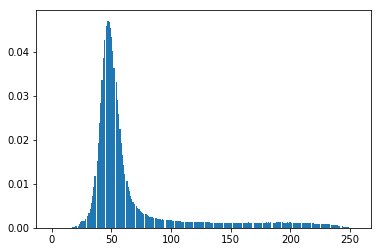

In [11]:
plt.hist(im_cropped_autoleveled.flatten(), bins=256, normed=True);
plt.show();

In [219]:
# contour_viz_fn = DETECTED_CELLS_DIR + '/MD589/MD589-N34-2015.07.30-18.20.43_MD589_2_0101/MD589-N34-2015.07.30-18.20.43_MD589_2_0101_blobContours_viz_farsight.png'
# contour_viz = cv2.imread(contour_viz_fn)
# contour_viz[5700:6700, 3000:4500]

# Binarization

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


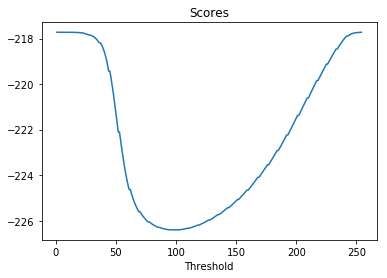

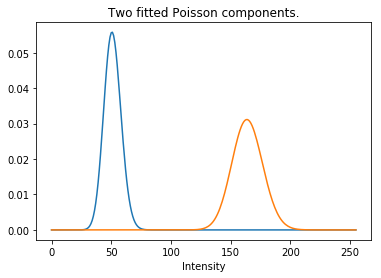

In [12]:
# Binarization: Poisson fitting.

counts, edges = np.histogram(im_cropped_autoleveled.flatten(), bins=256)
h = counts/float(np.sum(counts))
vals = edges[:-1]

# plt.hist(im_cropped_autoleveled.flatten(), bins=256, normed=True);
# plt.show();

mu = np.mean(im_cropped_autoleveled)

prior0s = np.zeros((256,))
prior1s = np.zeros((256,))
mu0s = np.zeros((256,))
mu1s = np.zeros((256,))

scores = {}
for t in range(0, 256):

    p0 = h[vals <= t].sum()
    p1 = 1 - p0
    hv = h * vals
    hv0 = hv[vals <= t].sum()
    hv1 = hv.sum() - hv0
    mu0 = hv0 / p0
    mu1 = hv1 / p1
    r = mu - p0*(np.log(p0)+mu0*np.log(mu0)) - p1*(np.log(p1)+mu1*np.log(mu1))
    scores[t] = r
    
    prior0s[t] = p0
    prior1s[t] = p1
    mu0s[t] = mu0
    mu1s[t] = mu1
    
poisson_thresh = np.argsort(scores.values())[0]

plt.plot(scores.values());
plt.title('Scores');
plt.xlabel('Threshold');
plt.show();

from scipy.stats import poisson
p0s = [poisson.pmf(v, mu0s[poisson_thresh]) for v in range(256)]
p1s = [poisson.pmf(v, mu1s[poisson_thresh]) for v in range(256)]
plt.plot(p0s);
plt.plot(p1s);
plt.title('Two fitted Poisson components.');
plt.xlabel('Intensity');
plt.show();

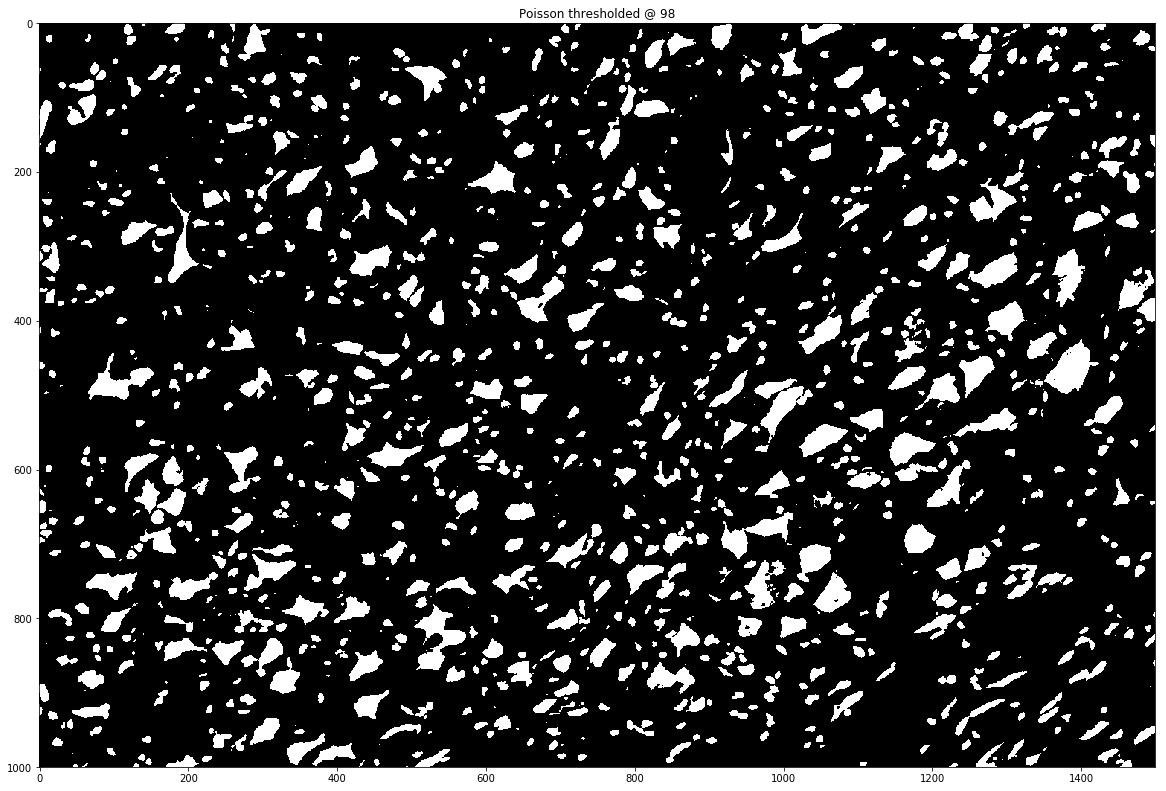

In [13]:
plt.figure(figsize=(20,20));
plt.imshow(im_cropped_autoleveled > poisson_thresh, cmap=plt.cm.gray)
plt.title('Poisson thresholded @ %d' % poisson_thresh);
plt.show();

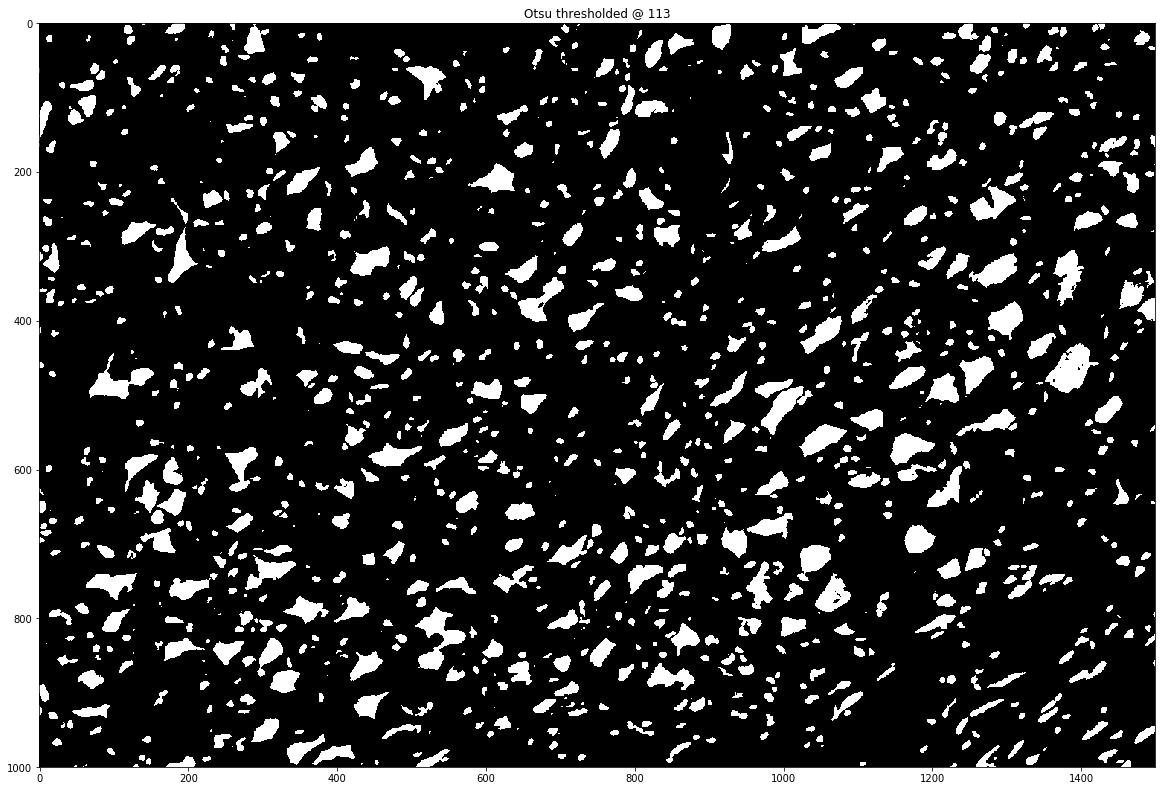

In [14]:
from skimage.filters import threshold_otsu
otsu_thresh = threshold_otsu(im_cropped_autoleveled)

plt.figure(figsize=(20,20));
plt.imshow(im_cropped_autoleveled > otsu_thresh, cmap=plt.cm.gray)
plt.title('Otsu thresholded @ %d' % otsu_thresh);
plt.show();

# Canny

/shared/MouseBrainAtlasXiang/cells/tmp.jpg

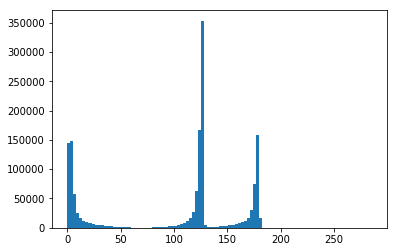

In [15]:
gy, gx = np.gradient(im_cropped_autoleveled)
g = np.sqrt(gx**2 + gy**2)

plt.hist(g.flatten(), bins=100);
viz = plt.cm.gray(g);
display_image(viz)

In [16]:
gr = (g - 50.)/(200.-50.)
gr = np.minimum(np.maximum(gr, 0), 1)
viz = plt.cm.gray(gr);

# plt.figure(figsize=(20,20));
# plt.imshow(viz, cmap=plt.cm.gray)
# plt.show();

from skimage.feature import canny

im_edges = canny(im_cropped_autoleveled, sigma=1., 
                 low_threshold=50, high_threshold=100, 
                 mask=None, use_quantiles=False)

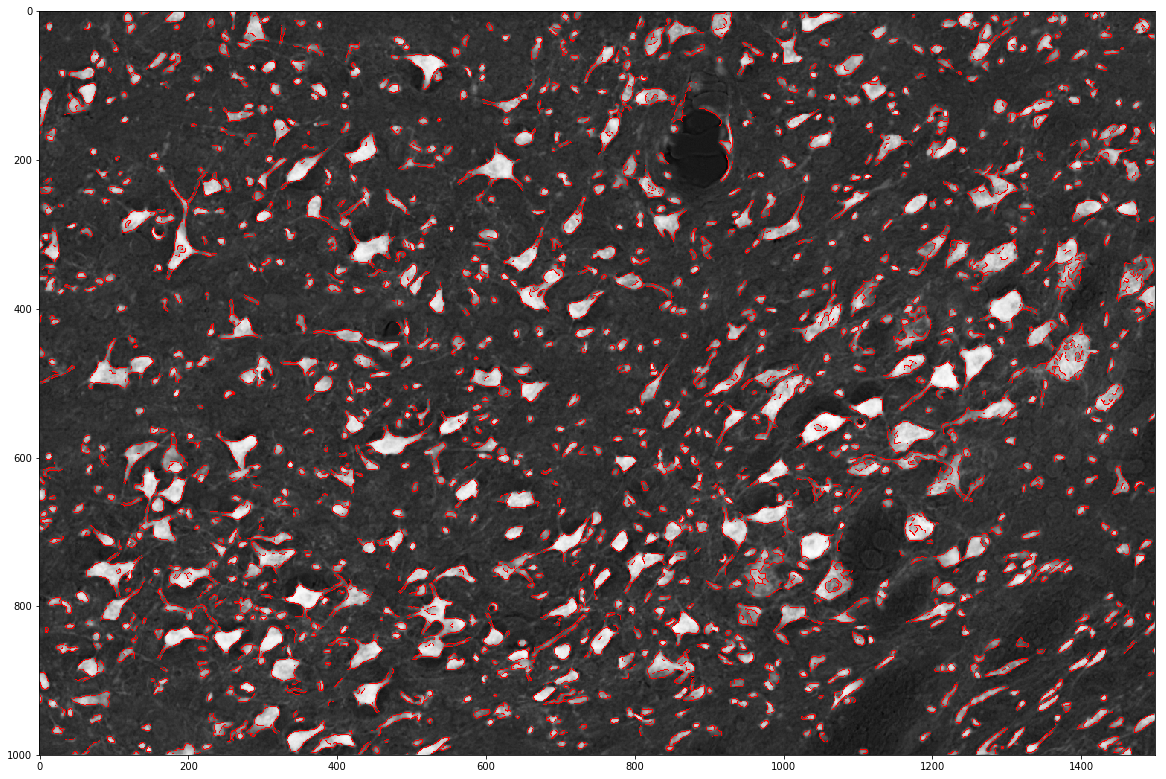

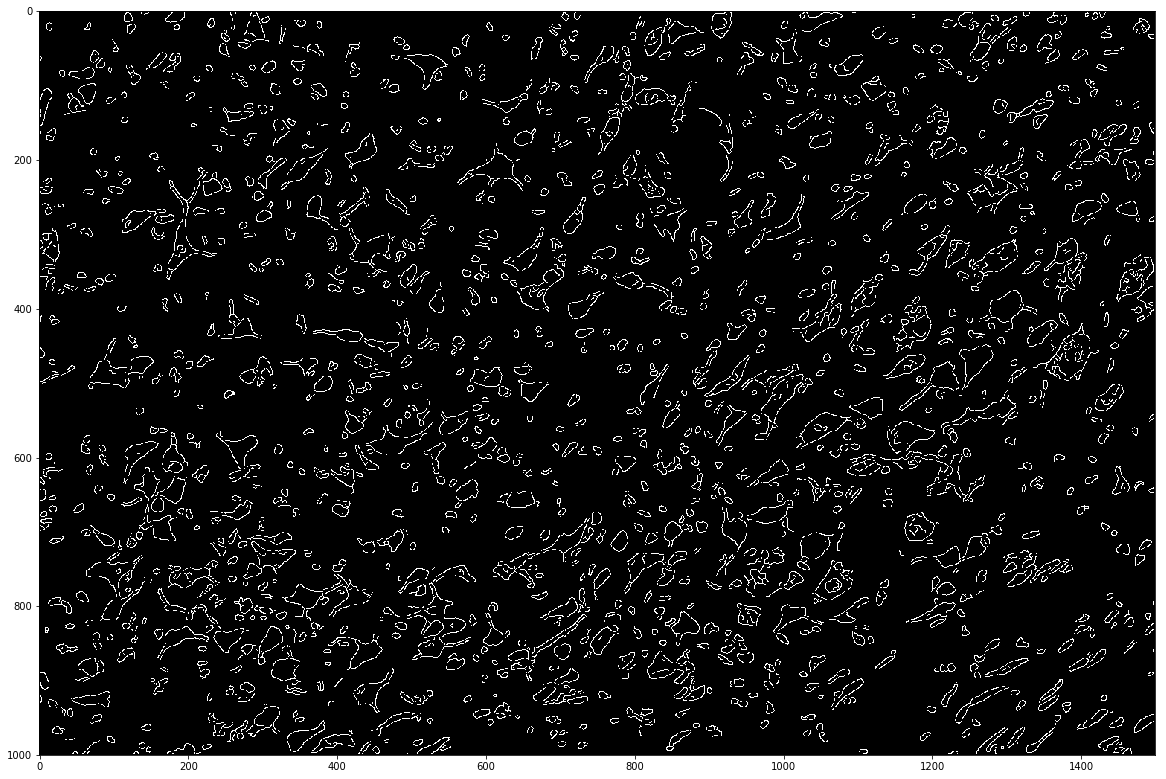

In [17]:
viz = gray2rgb(im_cropped_autoleveled)
viz[im_edges] = (255,0,0)

plt.figure(figsize=(20,20));
plt.imshow(viz, cmap=plt.cm.gray)
plt.show();

plt.figure(figsize=(20,20));
plt.imshow(im_edges, cmap=plt.cm.gray)
plt.show();

# Graphcut

In [53]:
import itertools
node_locations = list(itertools.product(range(im_cropped_h), range(im_cropped_w)))

In [52]:
y_diff = np.diff(im_cropped_autoleveled, axis=0)
x_diff = np.diff(im_cropped_autoleveled, axis=1)

In [199]:
sigma = 10.
sigma_sq = 2*sigma**2
beta = 1e-2

In [215]:
import maxflow

graph = maxflow.Graph[float](0, 0)

n = im_cropped_h * im_cropped_w
nodeids = graph.add_grid_nodes(n)

for node_id in range(n):
    
    y, x = node_locations[node_id]
       
    if node_id - 1 > 0 and y > 0 and y < im_cropped_h - 1 and x - 1 > 0 and x - 1 < im_cropped_w - 1:
        weight = np.exp(-x_diff[y,x-1]**2/sigma_sq)
        graph.add_edge(node_id, node_id - 1, weight, weight)
    
    if node_id + 1 < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-x_diff[y,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id + 1, weight, weight)
        
    if node_id - im_cropped_w > 0 and y - 1 > 0 and y - 1 < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-y_diff[y-1,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id - im_cropped_w, weight, weight)
    
    if node_id + im_cropped_w < n and y > 0 and y < im_cropped_h - 1 and x > 0 and x < im_cropped_w - 1:
        weight = np.exp(-y_diff[y,x]**2/sigma_sq)
        graph.add_edge(node_id, node_id + im_cropped_w, weight, weight)
        
    graph.add_tedge(node_id, beta * -np.log(p0s[im_cropped_autoleveled[y,x]]), 
                    beta * -np.log(p1s[im_cropped_autoleveled[y,x]]))

In [306]:
graph.maxflow();

node_mincut_labels = graph.get_grid_segments(nodeids)
mincut_labelmap = node_mincut_labels.reshape((im_cropped_h, im_cropped_w))

# print np.count_nonzero(~mincut_labelmap != im_cropped_threshed)

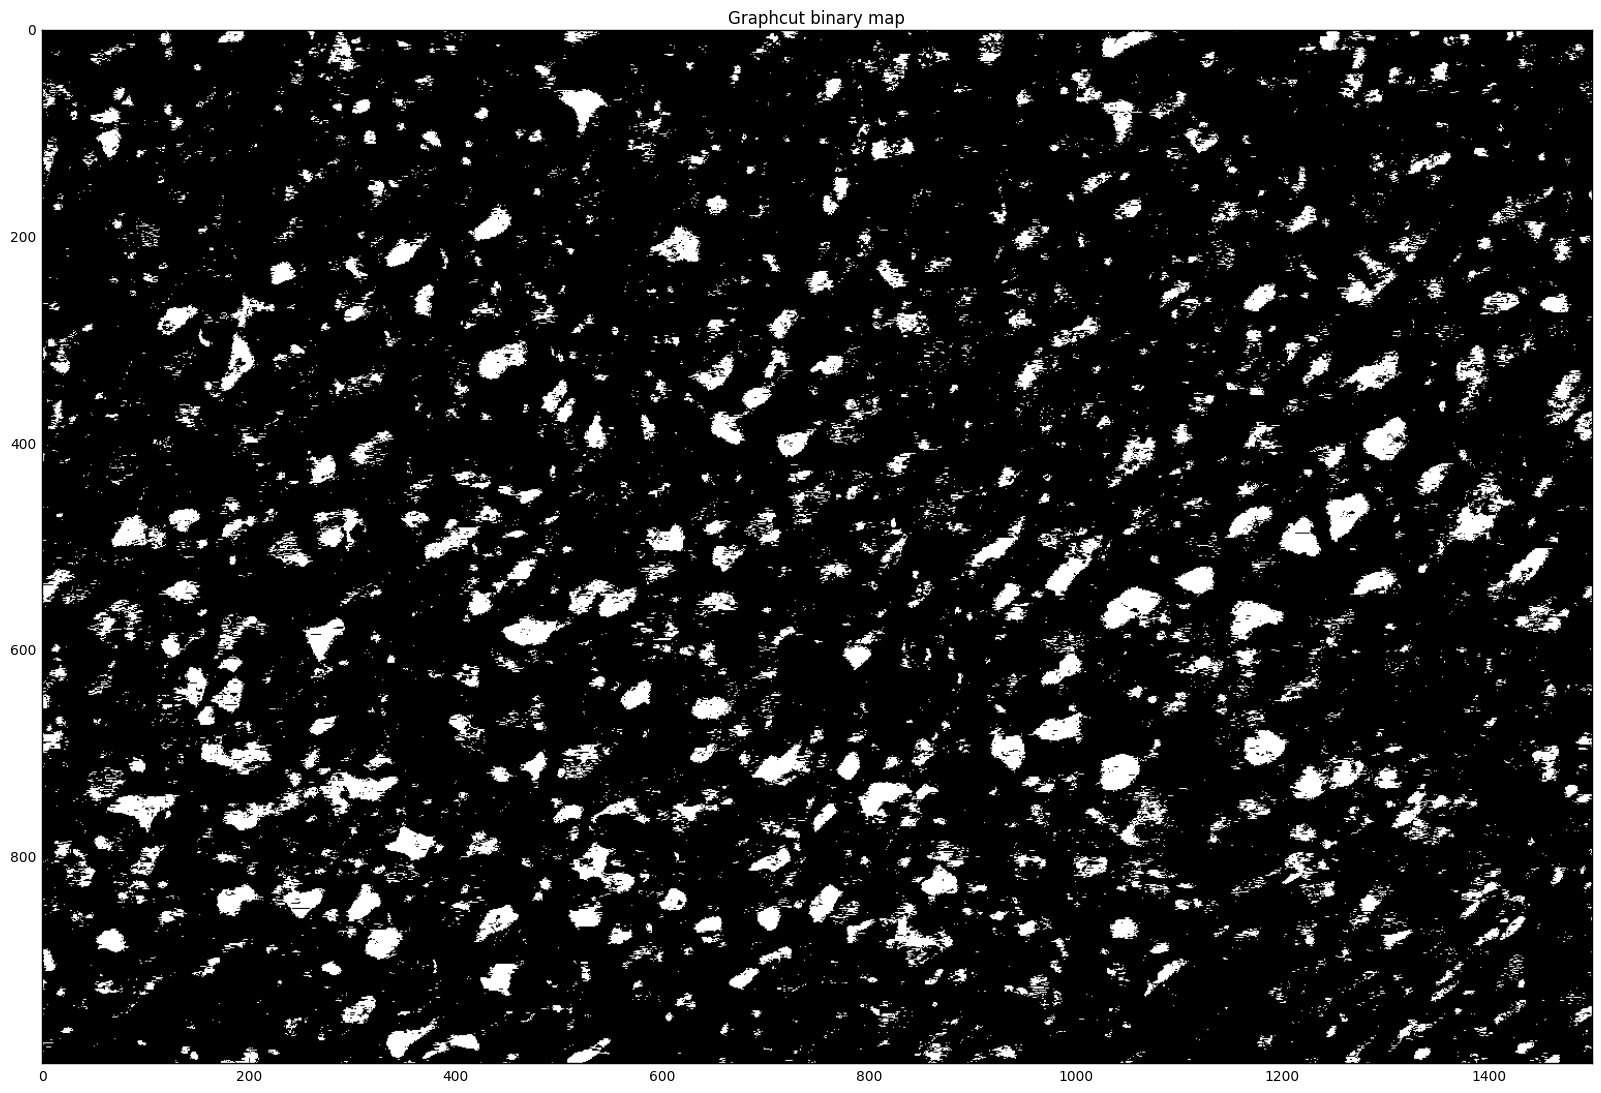

In [307]:
plt.figure(figsize=(20,20));
plt.imshow(~mincut_labelmap, cmap=plt.cm.gray)
plt.title('Graphcut binary map');
plt.show();

# SLIC

In [104]:
from skimage.segmentation import slic, mark_boundaries

In [115]:
slic_labelmap = slic(im_cropped_autoleveled, n_segments=10000, compactness=1.0, max_iter=1000, 
                           sigma=0, spacing=None, 
     multichannel=False, convert2lab=False, 
     enforce_connectivity=True, min_size_factor=0.5, 
     max_size_factor=3, slic_zero=False)
viz = mark_boundaries(im_cropped_autoleveled, label_img=slic_labelmap)
display_image(viz)

# LoG

In [92]:
from skimage.feature import blob_log, blob_dog

In [100]:
for threshold in np.arange(0.1, 1, 0.1):
    y_x_sigma_list = blob_log(im_cropped_autoleveled, min_sigma=3, max_sigma=50, num_sigma=10, 
                              threshold=threshold, overlap=0.9, log_scale=False)

    #     y_x_sigma_list = blob_dog(im_cropped_autoleveled, min_sigma=3, max_sigma=50, 
    #                                   threshold=threshold, overlap=0.9)

    viz = img_as_ubyte(gray2rgb(im_cropped_autoleveled))
    for y,x,sigma in y_x_sigma_list:
        cv2.circle(viz, (int(x), int(y)), radius=int(sigma), color=(255,0,0), thickness=2)

    fn = DETECTED_CELLS_DIR + '/MD589/MD589-N34-2015.07.30-18.20.43_MD589_2_0101/MD589-N34-2015.07.30-18.20.43_MD589_2_0101_LoG_thresh%.2f.png' % \
            threshold

    cv2.imwrite(fn, viz[..., ::-1])